In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [3]:
import MiniTools as mini
import MicroTools as micro
import param_scan

In [4]:
# from MiniTools import fit

In [5]:
def expAvg(Emin, Emax, L, gm4):
    if Emin == 0.0:
        Emin = 0.000001
    x = -4 * 1.267 * gm4**2 * L / (32 * np.pi)
    return (
        1
        / (Emax - Emin)
        * (
            (Emax * np.exp(x / Emax) - x * expi(x / Emax))
            - (Emin * np.exp(x / Emin) - x * expi(x / Emin))
        )
    )

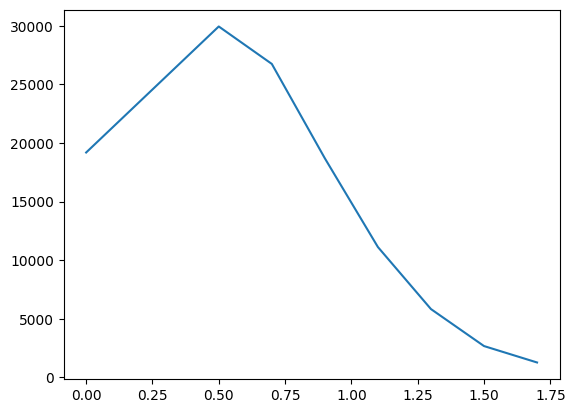

In [6]:
enu = [0, 0.5, 0.7, 0.9, 1.1, 1.3, 1.50, 1.7, 1.9]
data = [19189, 29943, 26748, 18692, 11123, 5830, 2674, 1273]

plt.plot(enu[:-1], data)

In [9]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 2-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 30

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
x_Vec = np.geomspace(1e-4, 0.9, Npoints)

# Range of gm4 for sterile decay model scanned over 0.1 to 100 in 30 steps
y_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = np.array(np.meshgrid(x_Vec, y_Vec)).T.reshape(-1, 2)
print(paramlist_decay)

[[1.00000000e-04 1.00000000e-01]
 [1.00000000e-04 1.26896100e-01]
 [1.00000000e-04 1.61026203e-01]
 ...
 [9.00000000e-01 6.21016942e+01]
 [9.00000000e-01 7.88046282e+01]
 [9.00000000e-01 1.00000000e+02]]


In [8]:
# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(param_scan.DecayReturnMicroBooNEChi2, paramlist_decay)
np.save(f"{path_results}/App_gm4_Um4sq_migrated_1_v3_normalized", res)

In [73]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 3-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 15

# Range of gm4 for sterile decay model scanned over 0.1 to 100
gm_Vec = np.geomspace(1e-1, 1e3, Npoints)

# Range of |U_{e4}|^2 scanned over 1e-4 to 1
e_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Cartesian product of grid
paramlist_decay = np.array(np.meshgrid(gm_Vec, e_Vec, mu_Vec)).T.reshape(-1, 3)
print(paramlist_decay)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(param_scan.DecayReturnMicroBooNEChi2_3D, paramlist_decay)
np.save(f"{path_results}/App_gm4_Ue4sq_Um4sq_migrated_v3_15*15*15", res)

[[1.00000000e-01 1.00000000e-04 1.00000000e-04]
 [1.00000000e-01 1.83478607e-04 1.00000000e-04]
 [1.00000000e-01 3.36643992e-04 1.00000000e-04]
 ...
 [1.00000000e+05 1.45554357e-01 4.90000000e-01]
 [1.00000000e+05 2.67061108e-01 4.90000000e-01]
 [1.00000000e+05 4.90000000e-01 4.90000000e-01]]


In [72]:
# ---------------------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 3-dimensions with 1 parameter fixed
# ---------------------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 15

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of gm4 for sterile decay model scanned over 0.1 to 100 in 30 steps
gm_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = np.array(np.meshgrid(gm_Vec, 1e-1, mu_Vec)).T.reshape(-1, 3)
print(paramlist_decay)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(param_scan.DecayReturnMicroBooNEChi2_3D, paramlist_decay)
np.save(f"{path_results}/Fixed_Ue4sq_1e-2_15*15_v3", res)

[[1.00000000e-01 1.00000000e-01 1.00000000e-04]
 [1.63789371e-01 1.00000000e-01 1.00000000e-04]
 [2.68269580e-01 1.00000000e-01 1.00000000e-04]
 [4.39397056e-01 1.00000000e-01 1.00000000e-04]
 [7.19685673e-01 1.00000000e-01 1.00000000e-04]
 [1.17876863e+00 1.00000000e-01 1.00000000e-04]
 [1.93069773e+00 1.00000000e-01 1.00000000e-04]
 [3.16227766e+00 1.00000000e-01 1.00000000e-04]
 [5.17947468e+00 1.00000000e-01 1.00000000e-04]
 [8.48342898e+00 1.00000000e-01 1.00000000e-04]
 [1.38949549e+01 1.00000000e-01 1.00000000e-04]
 [2.27584593e+01 1.00000000e-01 1.00000000e-04]
 [3.72759372e+01 1.00000000e-01 1.00000000e-04]
 [6.10540230e+01 1.00000000e-01 1.00000000e-04]
 [1.00000000e+02 1.00000000e-01 1.00000000e-04]
 [1.00000000e-01 1.00000000e-01 1.83478607e-04]
 [1.63789371e-01 1.00000000e-01 1.83478607e-04]
 [2.68269580e-01 1.00000000e-01 1.83478607e-04]
 [4.39397056e-01 1.00000000e-01 1.83478607e-04]
 [7.19685673e-01 1.00000000e-01 1.83478607e-04]
 [1.17876863e+00 1.00000000e-01 1.834786

In [69]:
# ---------------------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 4-dimensions with 1 parameter fixed
# ---------------------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 15

m4 = 1e3

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 0.5 in 15 steps
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of g for sterile decay model scanned over 0.1 to 100 in 15 steps
g_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Range of |U_{e4}|^2 scanned over 1e-4 to 0.5 in 15 steps
e_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Cartesian product of grid
paramlist_decay = np.array(np.meshgrid(g_Vec, m4, e_Vec, mu_Vec)).T.reshape(-1, 4)
print(paramlist_decay)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(param_scan.DecayReturnMicroBooNEChi2_4D, paramlist_decay)
np.save(f"{path_results}/Fixed_m4_1e3_15*15*15_v1", res)

[[1.00000000e-01 1.00000000e+03 1.00000000e-04 1.00000000e-04]
 [1.63789371e-01 1.00000000e+03 1.00000000e-04 1.00000000e-04]
 [2.68269580e-01 1.00000000e+03 1.00000000e-04 1.00000000e-04]
 ...
 [3.72759372e+01 1.00000000e+03 4.90000000e-01 4.90000000e-01]
 [6.10540230e+01 1.00000000e+03 4.90000000e-01 4.90000000e-01]
 [1.00000000e+02 1.00000000e+03 4.90000000e-01 4.90000000e-01]]
